# Tetracycline Resistance Model

(c) 2022 Tom Röschinger. This work is licensed under a 
[Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). 
All code contained herein is licensed under an 
[MIT license](https://opensource.org/licenses/MIT).

In [2]:
using SymPy, Polynomials, ColorSchemes, Turing, Distributions, LinearAlgebra, resistance_evolution, ForwardDiff, CairoMakie, CSV, DataFrames

resistance_evolution.plotting_style.default_makie!()
CairoMakie.activate!()


┌ Warning: SIMD capacity not detected by ScanByte, using scalar fallback
└ @ ScanByte /Users/tomroeschinger/.julia/packages/ScanByte/cr4PT/src/ScanByte.jl:11


In this notebook we go through everything bla bla

In [3]:
@syms a λ λ_0 κ_t K_d Δr j V_0 a_ex K_M P_out P_in

(a, λ, λ_0, κ_t, K_d, Δr, j, V_0, a_ex, K_M, P_out, P_in)

In [4]:
eq1 = (a * λ) / (κ_t * K_d) - Δr * (1 - λ/λ_0)

     ⎛  λ     ⎞    a⋅λ  
- Δr⋅⎜- ── + 1⎟ + ──────
     ⎝  λ₀    ⎠   K_d⋅κₜ

In [5]:
eq2 = a^2 * (-λ - P_out) + a * (-λ * K_M  + P_in * a_ex - P_out * K_M - V_0 * λ/λ_0 ) + P_in * a_ex * K_M

               2                 ⎛                              V₀⋅λ⎞
K_M⋅Pᵢₙ⋅aₑₓ + a ⋅(-Pₒᵤₜ - λ) + a⋅⎜-K_M⋅Pₒᵤₜ - K_M⋅λ + Pᵢₙ⋅aₑₓ - ────⎟
                                 ⎝                               λ₀ ⎠

In [6]:
expr1 = solve(eq1, a)[1]

K_d⋅Δr⋅κₜ⋅(-λ + λ₀)
───────────────────
        λ⋅λ₀       

In [7]:
expr2 = subs(eq2, a=>expr1)

                                                                        ⎛     
                 2   2   2                      2   K_d⋅Δr⋅κₜ⋅(-λ + λ₀)⋅⎜-K_M⋅
              K_d ⋅Δr ⋅κₜ ⋅(-Pₒᵤₜ - λ)⋅(-λ + λ₀)                        ⎝     
K_M⋅Pᵢₙ⋅aₑₓ + ─────────────────────────────────── + ──────────────────────────
                              2   2                                           
                             λ ⋅λ₀                                            

                         V₀⋅λ⎞
Pₒᵤₜ - K_M⋅λ + Pᵢₙ⋅aₑₓ - ────⎟
                          λ₀ ⎠
──────────────────────────────
λ⋅λ₀                          
                              

In [8]:
expr3 = expr2 * λ^2 * λ_0^2

       ⎛                                                                      
       ⎜                 2   2   2                      2   K_d⋅Δr⋅κₜ⋅(-λ + λ₀
 2   2 ⎜              K_d ⋅Δr ⋅κₜ ⋅(-Pₒᵤₜ - λ)⋅(-λ + λ₀)                      
λ ⋅λ₀ ⋅⎜K_M⋅Pᵢₙ⋅aₑₓ + ─────────────────────────────────── + ──────────────────
       ⎜                              2   2                                   
       ⎝                             λ ⋅λ₀                                    

  ⎛                              V₀⋅λ⎞⎞
)⋅⎜-K_M⋅Pₒᵤₜ - K_M⋅λ + Pᵢₙ⋅aₑₓ - ────⎟⎟
  ⎝                               λ₀ ⎠⎟
──────────────────────────────────────⎟
        λ⋅λ₀                          ⎟
                                      ⎠

In [9]:
expr4 = factor(expr3)

                    2                             2                  3        
K_M⋅K_d⋅Pₒᵤₜ⋅Δr⋅κₜ⋅λ ⋅λ₀ - K_M⋅K_d⋅Pₒᵤₜ⋅Δr⋅κₜ⋅λ⋅λ₀  + K_M⋅K_d⋅Δr⋅κₜ⋅λ ⋅λ₀ - K_

             2   2                2   2      2        2   2  2        2       
M⋅K_d⋅Δr⋅κₜ⋅λ ⋅λ₀  + K_M⋅Pᵢₙ⋅aₑₓ⋅λ ⋅λ₀  - K_d ⋅Pₒᵤₜ⋅Δr ⋅κₜ ⋅λ  + 2⋅K_d ⋅Pₒᵤₜ⋅Δ

 2   2           2        2   2   2      2   2   2  3        2   2   2  2     
r ⋅κₜ ⋅λ⋅λ₀ - K_d ⋅Pₒᵤₜ⋅Δr ⋅κₜ ⋅λ₀  - K_d ⋅Δr ⋅κₜ ⋅λ  + 2⋅K_d ⋅Δr ⋅κₜ ⋅λ ⋅λ₀ -

    2   2   2     2                      2                            2       
 K_d ⋅Δr ⋅κₜ ⋅λ⋅λ₀  - K_d⋅Pᵢₙ⋅aₑₓ⋅Δr⋅κₜ⋅λ ⋅λ₀ + K_d⋅Pᵢₙ⋅aₑₓ⋅Δr⋅κₜ⋅λ⋅λ₀  + K_d⋅

          3                 2   
V₀⋅Δr⋅κₜ⋅λ  - K_d⋅V₀⋅Δr⋅κₜ⋅λ ⋅λ₀

In [10]:
expr5 = collect(expr4, λ)

     2        2   2   2    3 ⎛                      2   2   2               ⎞ 
- K_d ⋅Pₒᵤₜ⋅Δr ⋅κₜ ⋅λ₀  + λ ⋅⎝K_M⋅K_d⋅Δr⋅κₜ⋅λ₀ - K_d ⋅Δr ⋅κₜ  + K_d⋅V₀⋅Δr⋅κₜ⎠ 

   2 ⎛                                        2                 2      2      
+ λ ⋅⎝K_M⋅K_d⋅Pₒᵤₜ⋅Δr⋅κₜ⋅λ₀ - K_M⋅K_d⋅Δr⋅κₜ⋅λ₀  + K_M⋅Pᵢₙ⋅aₑₓ⋅λ₀  - K_d ⋅Pₒᵤₜ⋅

  2   2        2   2   2                                            ⎞     ⎛   
Δr ⋅κₜ  + 2⋅K_d ⋅Δr ⋅κₜ ⋅λ₀ - K_d⋅Pᵢₙ⋅aₑₓ⋅Δr⋅κₜ⋅λ₀ - K_d⋅V₀⋅Δr⋅κₜ⋅λ₀⎠ + λ⋅⎝- K

                    2        2        2   2         2   2   2   2             
_M⋅K_d⋅Pₒᵤₜ⋅Δr⋅κₜ⋅λ₀  + 2⋅K_d ⋅Pₒᵤₜ⋅Δr ⋅κₜ ⋅λ₀ - K_d ⋅Δr ⋅κₜ ⋅λ₀  + K_d⋅Pᵢₙ⋅aₑ

          2⎞
ₓ⋅Δr⋅κₜ⋅λ₀ ⎠

In [11]:
println(expr5.coeff(λ, 4))
expr5.coeff(λ, 4)

0


0

In [12]:
println(expr5.coeff(λ, 3))
factor(expr5.coeff(λ, 3), K_d)

K_M*K_d*Δr*κ_t*λ_0 - K_d^2*Δr^2*κ_t^2 + K_d*V_0*Δr*κ_t


-K_d⋅Δr⋅κₜ⋅(-K_M⋅λ₀ + K_d⋅Δr⋅κₜ - V₀)

In [13]:
println(expr5.coeff(λ, 2))
factor(expr5.coeff(λ, 2), K_d)

K_M*K_d*P_out*Δr*κ_t*λ_0 - K_M*K_d*Δr*κ_t*λ_0^2 + K_M*P_in*a_ex*λ_0^2 - K_d^2*P_out*Δr^2*κ_t^2 + 2*K_d^2*Δr^2*κ_t^2*λ_0 - K_d*P_in*a_ex*Δr*κ_t*λ_0 - K_d*V_0*Δr*κ_t*λ_0


              2      2 ⎛       2   2       2   2   ⎞       ⎛                  
K_M⋅Pᵢₙ⋅aₑₓ⋅λ₀  - K_d ⋅⎝Pₒᵤₜ⋅Δr ⋅κₜ  - 2⋅Δr ⋅κₜ ⋅λ₀⎠ - K_d⋅⎝-K_M⋅Pₒᵤₜ⋅Δr⋅κₜ⋅λ₀

               2                                 ⎞
 + K_M⋅Δr⋅κₜ⋅λ₀  + Pᵢₙ⋅aₑₓ⋅Δr⋅κₜ⋅λ₀ + V₀⋅Δr⋅κₜ⋅λ₀⎠

In [14]:
println(expr5.coeff(λ, 1))
factor(expr5.coeff(λ, 1), K_d)

-K_M*K_d*P_out*Δr*κ_t*λ_0^2 + 2*K_d^2*P_out*Δr^2*κ_t^2*λ_0 - K_d^2*Δr^2*κ_t^2*λ_0^2 + K_d*P_in*a_ex*Δr*κ_t*λ_0^2


K_d⋅Δr⋅κₜ⋅λ₀⋅(-K_M⋅Pₒᵤₜ⋅λ₀ + K_d⋅(2⋅Pₒᵤₜ⋅Δr⋅κₜ - Δr⋅κₜ⋅λ₀) + Pᵢₙ⋅aₑₓ⋅λ₀)

In [15]:
println(expr5.coeff(λ, 0))
expr5.coeff(λ, 0)

-K_d^2*P_out*Δr^2*κ_t^2*λ_0^2


    2        2   2   2
-K_d ⋅Pₒᵤₜ⋅Δr ⋅κₜ ⋅λ₀ 

In [16]:
expr5

     2        2   2   2    3 ⎛                      2   2   2               ⎞ 
- K_d ⋅Pₒᵤₜ⋅Δr ⋅κₜ ⋅λ₀  + λ ⋅⎝K_M⋅K_d⋅Δr⋅κₜ⋅λ₀ - K_d ⋅Δr ⋅κₜ  + K_d⋅V₀⋅Δr⋅κₜ⎠ 

   2 ⎛                                        2                 2      2      
+ λ ⋅⎝K_M⋅K_d⋅Pₒᵤₜ⋅Δr⋅κₜ⋅λ₀ - K_M⋅K_d⋅Δr⋅κₜ⋅λ₀  + K_M⋅Pᵢₙ⋅aₑₓ⋅λ₀  - K_d ⋅Pₒᵤₜ⋅

  2   2        2   2   2                                            ⎞     ⎛   
Δr ⋅κₜ  + 2⋅K_d ⋅Δr ⋅κₜ ⋅λ₀ - K_d⋅Pᵢₙ⋅aₑₓ⋅Δr⋅κₜ⋅λ₀ - K_d⋅V₀⋅Δr⋅κₜ⋅λ₀⎠ + λ⋅⎝- K

                    2        2        2   2         2   2   2   2             
_M⋅K_d⋅Pₒᵤₜ⋅Δr⋅κₜ⋅λ₀  + 2⋅K_d ⋅Pₒᵤₜ⋅Δr ⋅κₜ ⋅λ₀ - K_d ⋅Δr ⋅κₜ ⋅λ₀  + K_d⋅Pᵢₙ⋅aₑ

          2⎞
ₓ⋅Δr⋅κₜ⋅λ₀ ⎠

In [17]:

function solve_polynomial(aex, λ0, κt, Kd, KM, j, V0, Δr)
    c = zeros(4)
    c1 = κt * Kd * Δr
    c[4] = c1 * (KM * λ0 - c1 + V0)
    c[3] = KM * j * aex * λ0^2 - c1^2 * (j - 2λ0) - c1 * λ0 * (-KM * j  + KM * λ0 + j * aex + V0)
    c[2] = c1 * λ0 * (-KM * j * λ0 + c1 * (2j - λ0) + j * aex * λ0)
    c[1] = -Kd^2*j*Δr^2*κt^2*λ0^2
    pol = Polynomial(c)
    return Polynomials.roots(pol)
end


solve_polynomial (generic function with 1 method)

In [18]:
_aex = 0  # µM
_λ0 = 0.68  # h**-1
_κt = 0.06  # µM**-1 h**-1
_Kd = .1  # µM
_KM = 100 # µM
_j = 10# h**-1
Pin = 10
Pout = 3
_V0 = 0
_Δr = 46.5  # µM


a_ex_range = [0, 0.1, 0.26, 0.4, 0.6, 1]
sol_list = zeros(ComplexF64, 3, length(a_ex_range))
for (i, x) in enumerate(a_ex_range)
    # Pack parameters together
    args = (x, _λ0, _κt, _Kd, _KM, _j, _V0, _Δr)
    # Find roots
    sol_list[:, i] = solve_polynomial(args...)
end

In [19]:
sol_list[:, 2]

3-element Vector{ComplexF64}:
    -12.309686480501533 + 0.0im
 -0.0028014943665923427 + 0.0im
      0.552410494838448 + 0.0im

## Writing Generative Model

Now we are going to write down the model in a Bayesian way and try out various priors.

\begin{align*}
\lambda_0 &= 0.68 h^{-1},\\[.5em]
\kappa_t &= 0.06 \mu M^{-1} h^{-1},\\[.5em]
K_d &= 0.1 \mu M,\\[.5em]
K_M &= 10 \mu M,\\[.5em]
\Delta r &= 46.5 \mu M,\\[.5em]
\log j &\sim \text{Norm}(2, 2),\\[.5em]
j &= 10^{\log j} \times 1 s^{-1},\\[.5em]
\log P_\mathrm{in} &\sim \text{Norm}(2, 2),\\[.5em]
P_\mathrm{in} &= 10^{\log P_\mathrm{in}} \times 1 s^{-1},\\[.5em]
\log P_\mathrm{out} &\sim \text{Norm}(2, 2),\\[.5em]
P_\mathrm{out} &= 10^{\log P_\mathrm{out}} \times 1 s^{-1},\\[.5em]
\log V_0 &\sim \text{Norm}(2, 2),\\[.5em]
V_0  &= 10^{\log V_0 } \times 1 \mu M s^{-1}
\end{align*}

In [24]:
@model function fit_growth_syn(growth_rates, aex_arr, aex_ppc)
    
    y_ppc = zeros(Float64, length(aex_ppc))

    # Priors
    log_j ~ Normal(2, 2)
    log_V0 ~ Normal(2, 2)
    log_sigma ~ Normal(-3, 1)
    
    # Transform Parameters
    sigma = float(10^log_sigma)
    j = 10^log_j
    V0 = 10^log_V0
    
    # Fixed Parameters
    λ0 = 0.68  
    κt = 0.06
    Kd = .1
    KM = 10
    Δr = 46.5
    
    for (i, aex) in enumerate(aex_arr)
        if typeof(V0) == ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 3}
            x = [aex, λ0, κt, Kd, KM, ForwardDiff.value(j), ForwardDiff.value(V0), Δr]
        else
            x = [aex, λ0, κt, Kd, KM, j, V0, Δr]
        end
        solutions = solve_polynomial(x...)
        
        y = [imag(x) == 0 ? real(x)/λ0 : missing for x in solutions]
        y = filter(x -> !ismissing(x) && (x > 0), y)
        if length(y) == 3
            deleteat!(y, 2)
            opt_y = y[argmin([(λ - root)^2 for root in y])]
        else
            opt_y = y[1]
       end
        

        growth_rates[i] ~ Normal(opt_y, sigma)
    end
    for (i, aex) in enumerate(aex_ppc)
        if typeof(V0) == ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 3}
            x = [aex, λ0, κt, Kd, KM, ForwardDiff.value(j), ForwardDiff.value(V0), Δr]
        else
            x = [aex, λ0, κt, Kd, KM, j, V0, Δr]
        end
        solutions = solve_polynomial(x...)
        
        y = [imag(x) == 0 ? real(x)/λ0 : missing for x in solutions]
        y = filter(x -> !ismissing(x) && (x > 0), y)
        if length(y) == 3
            deleteat!(y, 2)
            opt_y = y[argmin([(λ - root)^2 for root in y])]
        else
            opt_y = y[1]
        end
        if typeof(sigma) == ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 3}
            y_ppc[i] = rand(Normal(opt_y / λ0, ForwardDiff.value(sigma)), 1)[1]
        else
            y_ppc[i] = rand(Normal(opt_y, sigma), 1)[1]
        end

    end
    return V0, j, sigma, y_ppc
end

fit_growth_syn (generic function with 2 methods)

In [25]:
y = Float64[]
for i in 1:length(a_ex_range)
    args = (a_ex_range[i], _λ0, _κt, _Kd, _KM, _j, 0, _Δr)
    solutions = solve_polynomial(args...)
    println(solutions)
    _y = [imag(x) == 0 ? real(x) : missing for x in solutions]
    push!(y, _y[3])
end

[-9.999999999999993, -0.002801494366592343, 0.6800000000000003]
[-12.309686480501533, -0.0028014943665923427, 0.552410494838448]
[-16.0798081795807, -0.0028014943665923436, 0.4228906168566823]
[-19.419271557329584, -0.0028014943665923427, 0.3501676146772568]
[-24.22436502617409, -0.0028014943665923427, 0.2807091121956212]
[-33.893388953043114, -0.0028014943665923427, 0.20062909641230958]


In [26]:
println(y)

[0.6800000000000003, 0.552410494838448, 0.4228906168566823, 0.3501676146772568, 0.2807091121956212, 0.20062909641230958]


In [27]:
chn = sample(fit_growth_syn(y, a_ex_range, a_ex_range), NUTS(0.65), 1000)
chains_params = Turing.MCMCChains.get_sections(chn, :parameters)
gen = generated_quantities(fit_growth_syn(y, a_ex_range, a_ex_range), chains_params)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/tomroeschinger/.julia/packages/Turing/S4Y4B/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


1000×1 Matrix{Tuple{Float64, Float64, Float64, Vector{Float64}}}:
 (6.090110711215361, 1081.698797587477, 0.2159774224079172, [0.6683822351561217, 0.614677479031331, 0.799993055902601, 0.6400115609414684, 0.5193482744635943, 0.5204312724232739])
 (1.5138082995757327, 1019.8862411639108, 0.16327685062400732, [1.1954459856467292, 0.7488449279694452, 0.5058638027469912, 0.6577766308788896, 0.19755987278429196, 0.3766789763771558])
 (476.58683469832846, 185.2602258947824, 0.20969511496707458, [0.9825383796090956, 0.67203586552479, 0.7579533612650912, 0.812063773765427, 0.5720376512575123, 0.46155015235118446])
 (55.85748407386252, 11.359239908828918, 0.20802596409757113, [0.7030314190105493, 0.9264366746360101, 0.8104389910363143, 0.5027431624431734, 0.48387314587003044, 0.1372588632909125])
 (73.23057141616093, 6.605724520830192, 0.20357897473616568, [1.1399608732280053, 0.5521185168352659, 0.5214011473745168, 0.5749791172755292, 0.07182203733187476, 0.8855461786659138])
 (3.9142078218606

In [28]:
y_ppc = mean(hcat([x[end] for x in gen]...), dims=2)[2:end] |> vec

5-element Vector{Float64}:
 0.8048595175316314
 0.623082855632125
 0.5105809605341888
 0.42251225138698756
 0.29703829340402294

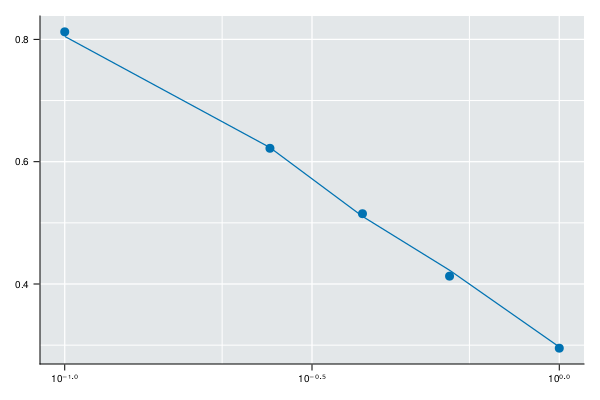

In [29]:
y_ppc = mean(hcat([x[end] for x in gen]...), dims=2)[2:end] |> vec
fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1], xscale=log10)
scatter!(ax, a_ex_range[2:end], y[2:end] ./ _λ0)

lines!(ax, a_ex_range[2:end], y_ppc)

fig

In [30]:
files = [
    "20220714_r2_allstrains_tc",
    "20220715_r3_allstrains_tc",
    "20220722_r1_allstrains_tc",
    "20220723_r2_allstrains_tc",
    "20220725_r3_allstrains_tc"
    ]

df = DataFrame()

for file in files
    _df = CSV.read("../../processing/plate_reader/" * file * "/exp_analysis_summary.csv", DataFrame)
    insertcols!(_df, 5, :tc => map(x -> parse(Float64, split(x, "_")[1]), _df.pos_selection))
    insertcols!(_df, 5, :rep => map(x -> parse(Int64, split(x, "_")[2]), _df.strain))
    insertcols!(_df, 5, :date => parse(Int64, split(file, "_")[1]))
    _df.strain = map(x -> split(x, "_")[1], _df.strain)
    df = vcat(df, _df)
end
first(df, 5)

,run,strain,pos_selection,well,date,rep,tc,exp_growth_rate
,String3,SubStrin…,String15,String3,Int64,Int64,Float64,Float64
1,r2,MG1655,0_µg/ml_tc,A02,20220714,1,0.0,0.00908367
2,r2,3.19,0_µg/ml_tc,A03,20220714,1,0.0,0.00920603
3,r2,IW,0_µg/ml_tc,A04,20220714,1,0.0,0.0103141
4,r2,MG1655,0.1_µg/ml_tc,A05,20220714,1,0.1,0.0074149
5,r2,3.19,0.1_µg/ml_tc,A06,20220714,1,0.1,0.00850656


In [31]:
df_MG = df[(df.strain .== "MG1655"), :]

,run,strain,pos_selection,well,date,rep,tc,exp_growth_rate
,String3,SubStrin…,String15,String3,Int64,Int64,Float64,Float64
1,r2,MG1655,0_µg/ml_tc,A02,20220714,1,0.0,0.00908367
2,r2,MG1655,0.1_µg/ml_tc,A05,20220714,1,0.1,0.0074149
3,r2,MG1655,0.25_µg/ml_tc,A10,20220714,1,0.25,0.00593602
4,r2,MG1655,0_µg/ml_tc,B03,20220714,2,0.0,0.0100495
5,r2,MG1655,0.1_µg/ml_tc,B05,20220714,2,0.1,0.0079365
6,r2,MG1655,0_µg/ml_tc,C04,20220714,1,0.0,0.00952114
7,r2,MG1655,0.1_µg/ml_tc,C05,20220714,1,0.1,0.00782161
8,r2,MG1655,0.1_µg/ml_tc,D05,20220714,2,0.1,0.00907718
9,r2,MG1655,0_µg/ml_tc,E01,20220714,2,0.0,0.00999429


In [32]:
@model function fit_growth(growth_rates, aex_arr, aex_ppc)
    
    y_ppc = zeros(Float64, length(aex_ppc))

    # Priors
    log_j ~ Normal(2, 2)
    log_V0 ~ Normal(2, 2)
    log_sigma ~ Normal(-3, 2)
    λ0 ~ truncated(Normal(0, 0.01), 0, Inf)
    
    # Transform Parameters
    sigma = float(10^log_sigma)
    j = 10^log_j
    V0 = 10^log_V0
    
    # Fixed Parameters
    κt = 0.06
    Kd = .1
    KM = 10
    Δr = 46.5
    
    for (i, aex) in enumerate(aex_arr)
        if typeof(V0) == ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 4}
            x = [aex, ForwardDiff.value(λ0), κt, Kd, KM, ForwardDiff.value(j), ForwardDiff.value(V0), Δr]
        else
            x = [aex, λ0, κt, Kd, KM, j, V0, Δr]
        end
        solutions = solve_polynomial(x...)
        
        y = [imag(x) == 0 ? real(x) : missing for x in solutions]
        y = filter(x -> !ismissing(x) && (x > 0), y)
        if length(y) == 3
            deleteat!(y, 2)
            opt_y = y[argmin([(λ - root)^2 for root in y])]
        else
            opt_y = y[1]
       end
        

        growth_rates[i] ~ Normal(opt_y, sigma)
    end
    for (i, aex) in enumerate(aex_ppc)
        if typeof(V0) == ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 4}
            x = [aex, ForwardDiff.value(λ0), κt, Kd, KM, ForwardDiff.value(j), ForwardDiff.value(V0), Δr]
        else
            x = [aex, λ0, κt, Kd, KM, j, V0, Δr]
        end
        solutions = solve_polynomial(x...)
        
        y = [imag(x) == 0 ? real(x) : missing for x in solutions]
        y = filter(x -> !ismissing(x) && (x > 0), y)
        if length(y) == 3
            deleteat!(y, 2)
            opt_y = y[argmin([(λ - root)^2 for root in y])]
        else
            opt_y = y[1]
        end
        if typeof(sigma) == ForwardDiff.Dual{ForwardDiff.Tag{Turing.TuringTag, Float64}, Float64, 4}
            y_ppc[i] = rand(Normal(opt_y, ForwardDiff.value(sigma)), 1)[1]
        else
            y_ppc[i] = rand(Normal(opt_y, sigma), 1)[1]
        end

    end
    return λ0, V0, j, sigma, y_ppc
end

fit_growth (generic function with 2 methods)

In [33]:
aex_ppc  = df_MG[!, :tc] |> unique |> sort
chn = sample(fit_growth(df_MG[!, :exp_growth_rate], df_MG[!, :tc], aex_ppc), NUTS(0.65), 1000)
chains_params = Turing.MCMCChains.get_sections(chn, :parameters)
gen = generated_quantities(fit_growth(df_MG[!, :exp_growth_rate], df_MG[!, :tc], aex_ppc), chains_params)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroeschinger/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroeschinger/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/tomroeschinger/.julia/packages/Turing/S4Y4B/src/inference/hmc.jl:188
Sampling:   4%|█▊                                       |  ETA: 5:47:41

5452.307599556206


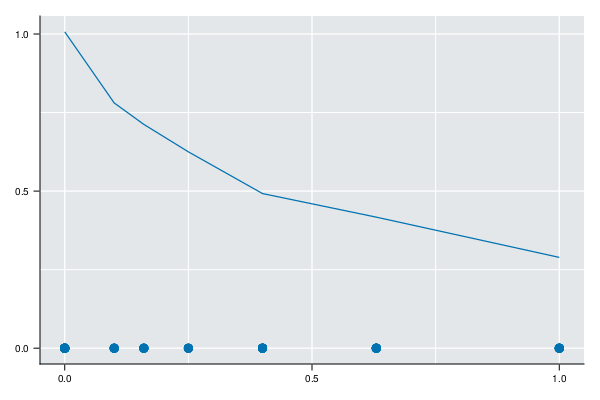

In [ ]:
y_ppc = mean(hcat([x[end] for x in gen]...), dims=2) |> vec

λ_0_infer = hcat([x[1] for x in gen]...) |> mean
println(λ_0_infer)
fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1])
scatter!(ax, df_MG[!, :tc], df_MG[!, :exp_growth_rate])

lines!(ax, aex_ppc, y_ppc)

fig

In [ ]:
gen

1000×1 Matrix{Tuple{Float64, Float64, Float64, Vector{Float64}}}:
 (0.04290018401843456, 36.3417316666039, 0.7979321051821697, [1.4286248945660043, 1.2829301309743388, 0.7095790680981101, 0.47140696072692734, 1.656665430103685, 1.143037365474611, 0.643107278502845])
 (0.7881481658332842, 14.23437500406102, 0.7795028434354134, [1.9650501622712415, 0.6234915283512533, 0.5435850392881073, 1.36948210177138, -0.50621468440705, 2.1085897304161203, -0.09966764023043684])
 (4.240141691207039, 24.10105665338506, 0.7760431037760763, [1.8342133476278968, 0.32008977365371066, -0.0324857771682906, 1.2950304592835686, 0.016334960500800744, 0.5898338377220864, 1.360656406904501])
 (4.240141691207039, 24.10105665338506, 0.7760431037760763, [0.5443879549998492, 1.6165610793746847, 0.8523254161646598, 1.1152529991210647, 0.17491044785597815, 0.6783401022579583, 0.6546446276629418])
 (7.52630314816232, 98.94475340870184, 0.774662702406743, [0.023903253780572564, 0.8307522740622075, 0.8542312849378237, 0.